In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
# from torch.utils.tensorboard import SummaryWriter

from PIL import Image
from skimage.color import rgba2rgb
import cv2
from IPython.display import display, clear_output
from math import *
import time

from os import makedirs, path
from copy import deepcopy

from tqdm import tqdm

from iafCA import iafCA
import pygame
from physicsCA import min_max

pygame 2.0.1 (SDL 2.0.14, Python 3.9.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
def LMB_make(state, r=5, s=1):
    '''
    left click to make
    r: radius of brush
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)
    
    # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = torch.exp(-rm**2 / s**2)
    blur = torch.where(rm <= 1., blur, 0.) # circular mask
    
    xslice = range(xcl - r, xcl + r)
    yslice = range(ycl - r, ycl + r)
    for count_i, i in enumerate(xslice):
        for count_j, j in enumerate(yslice):
            i = i % RESX
            j = j % RESY
            state[:, 1, i, j] = state[:, 1, i, j] + 5.
    return state
    
    
def RMB_del(state, r=5, s=1):
    '''
    right click to erase
    r: radius of eraser
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)
    
    # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = (1 - torch.exp(-rm**2 / s**2))
    blur = torch.where(rm <= 1., blur, 1.) # circular mask
    
    xslice = range(xcl - r, xcl + r)
    yslice = range(ycl - r, ycl + r)
    for count_i, i in enumerate(xslice):
        for count_j, j in enumerate(yslice):
            i = i % RESX
            j = j % RESY
            state[:, 1, i, j] = state[:, 1, i, j] - 0.2
    return state

def WHEEL_permute(cdim_order, direction):
    cdim_order = np.mod(np.add(cdim_order, direction), 7)
    
    return cdim_order

def min_max(mat):
    return (mat - mat.min()) / (mat.max() - mat.min())

# Test

In [3]:
RADIUS=20
kernel_increment = .2
ca = iafCA(RADIUS=RADIUS).cuda() 

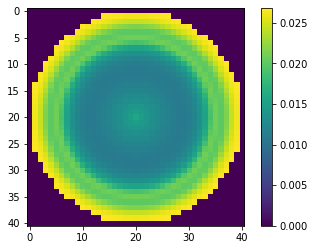

In [4]:
plt.imshow(ca.rule.nearest_neighbours.data[0, 0].cpu().numpy())
plt.colorbar()

In [5]:
# brush properties
r = 20
s = 1

### Init Webcam

In [6]:
cap = cv2.VideoCapture(0)

# Check if the webcam is opened correctly
if not cap.isOpened():
    raise IOError("Cannot open webcam")

# while True:
#     ret, frame = cap.read()
#     frame = cv2.resize(frame, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
#     cv2.imshow('Input', frame)

#     c = cv2.waitKey(1)
#     if c == 27:
#         break

# cap.release()
# cv2.destroyAllWindows()

In [7]:
ret, frame = cap.read()
frame = cv2.resize(frame, None, fx=1, fy=1, interpolation=cv2.INTER_AREA)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [8]:
target_file = 'target/pug.png'
target_img = Image.open(target_file).convert('L')
target_img = np.array(target_img).transpose() / 255.0
target_img = torch.cuda.FloatTensor(target_img)
inject_scale = 10.
inject_img = False

In [9]:
def kernel_delta(state):
    unf_s = F.unfold(state[:, [0], ...], 2 * RADIUS + 1, padding=RADIUS)
    

In [10]:
# resolution of grid
RESX= 640 #target_img.shape[0] # 1280
RESY= 640 #target_img.shape[1]  # 720

# RESX= 1000 # 1280
# RESY= 1000  # 720

# pygame stuff
######################################
pygame.init()
size = RESX, RESY

win = pygame.display.set_mode((RESX, RESY))

screen = pygame.Surface(size)
UPSCALE = 1
RESXup, RESYup = int(RESX*UPSCALE), int(RESY*UPSCALE)
upscaled_screen = pygame.display.set_mode([RESXup, RESYup])

# webcam stuff
######################################
inject_webcam = False
wbcam_fx = int(RESX / frame.shape[0])
wbcam_fy = int(RESX / frame.shape[1]) #RESY 
img_norm = 1/255. 

running = True
time_ticking = True
self_organize = False
LMB_trigger = False
RMB_trigger = False
WHEEL_trigger = False
cdim_order = np.arange(0, 6)

clock = pygame.time.Clock()
font = pygame.font.SysFont("Noto Sans", 12)
def update_fps(clock, font):
    fps = str(int(clock.get_fps()))
    fps_text = font.render(fps, 1, pygame.Color("white"))
    fps_bg = pygame.Surface((fps_text.get_height(),fps_text.get_width()))  # the size of your rect
    fps_bg.set_alpha(50)                # alpha level
    fps_bg.fill((255,255,255))           # this fills the entire surface

    fps_surf = pygame.Surface((fps_bg.get_height(), fps_bg.get_width()))
    fps_surf.blit(fps_bg, (0, 0))
    fps_surf.blit(fps_text, (0, 0))
    return fps_surf
######################################


state = ca.initGrid((RESX, RESY))
og_kernel = ca.rule.nearest_neighbours
kernel_scale = 1

# inject noise
signal_injection = torch.zeros(size=state.shape)
noise_amp = 1.
noise_idx = slice(4, 10)

update_rate = 1.
ticker = 0.
sink = False
export_imgs = False
imgs = []

with torch.no_grad():
    while running:              
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                
            if event.type == pygame.MOUSEBUTTONDOWN:
                if event.button == 1:
                    LMB_trigger = True
                if event.button == 3:
                    RMB_trigger = True
            if event.type == pygame.MOUSEBUTTONUP:
                if event.button == 1:
                    LMB_trigger = False
                if event.button == 3:
                    RMB_trigger = False
                    
            if event.type == pygame.MOUSEWHEEL:
                WHEEL_trigger = True
                direction = -event.y
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_LEFTBRACKET:
                update_rate += -0.5
            if event.type == pygame.KEYDOWN and event.key == pygame.K_RIGHTBRACKET:
                update_rate += 0.5
            
            if event.type == pygame.MOUSEBUTTONUP and event.button == 2:
                # scroll through channel dims
                cdim_order = np.arange(0, state.shape[1])
                    
#             if event.type == pygame.KEYDOWN and event.key == pygame.K_SPACE:
#                 # pick another random CA
#                 ca = CA(CHANNELS=CHANNELS, FILTERS=FILTERS, NET_SIZE=NET_SIZE, RADIUS=RADIUS).cuda() 
                
                
#             if event.type == pygame.VIDEORESIZE:
#                 print(event.w, event.h)
#                 surface = pygame.display.set_mode((event.w, event.h),
#                                               pygame.RESIZABLE)
            if event.type == pygame.KEYDOWN and event.key == pygame.K_k:
                ca.rule.nearest_neighbours = ca.rule.generate_cppn_kernel() 
                og_kernel = ca.rule.nearest_neighbours
            if event.type == pygame.KEYDOWN and event.key == pygame.K_UP:
                kernel_scale += kernel_increment
                ca.rule.nearest_neighbours = og_kernel * kernel_scale
            if event.type == pygame.KEYDOWN and event.key == pygame.K_DOWN:
                kernel_scale -= kernel_increment
                ca.rule.nearest_neighbours = og_kernel * kernel_scale
            if event.type == pygame.KEYDOWN and event.key == pygame.K_w:
                inject_webcam = not inject_webcam
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_s:
                sink = not sink
            if event.type == pygame.KEYDOWN and event.key == pygame.K_e:
                export_imgs = not export_imgs
            if event.type == pygame.KEYDOWN and event.key == pygame.K_p:
                # pause/toggle time
                time_ticking = not time_ticking
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_r:
                # start from seed 
                state = ca.initGrid((RESX, RESY))
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_g:
                # inject img (ginger)
                inject_img = not inject_img
                # if inject_img:
                #     ca.rule.target_rate_mat = 6 + (target_img.unsqueeze(0).unsqueeze(0) * inject_scale - inject_scale/2)
                # else:
                #     ca.rule.target_rate_mat = torch.ones_like(ca.rule.target_rate_mat) * ca.rule.target_rate
                    
                

        mouse_pos = pygame.mouse.get_pos()
        if LMB_trigger:
            state = LMB_make(state, r=r, s=s)
        if RMB_trigger:
            state = RMB_del(state, r=r, s=s)
            
        if WHEEL_trigger:
            cdim_order = WHEEL_permute(cdim_order, direction)
            WHEEL_trigger = False
            
#        nx = state.cpu()[:, cdim_order].numpy()[0, 0, :, :].transpose(1, 2, 0)
        # nx = state.cpu().numpy()[0, cdim_order[0], :, :]
#        nx = state.cpu().numpy()[0, [0, 1, 5], :, :].transpose(1, 2, 0)
#         nx = state.cpu()[0, cdim_order].numpy().transpose(1, 2, 0)
        nx = state[0, cdim_order[0], :, :].cpu().numpy()
        # nx = state[0, [0, 1, -2], :, :]
        # nx = np.stack([min_max(np.log10(1 + c)) for c in nx], axis=-1) * 255.
        nx = nx * 255.

        if time_ticking:
            state = ca.forward(state)
            ticker += 1
            
            if inject_webcam:
                ret, frame = cap.read()
                frame = cv2.resize(frame, None, fx=wbcam_fx, fy=wbcam_fy, interpolation=cv2.INTER_AREA)
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).transpose()
                frame = torch.cuda.FloatTensor(frame) * img_norm * update_rate
                state[0, 1, 0:frame.shape[0], 0:frame.shape[1]] = state[0, 1, 0:frame.shape[0], 0:frame.shape[1]] + frame
                # state[0, 4, 0:frame.shape[0], 0:frame.shape[1]] = state[0, 4, 0:frame.shape[0], 0:frame.shape[1]] - 0.5 * frame
                
            if inject_img:
                state[:, [1], ...] += (target_img.unsqueeze(0).unsqueeze(0) * inject_scale)
                
    
        if sink and time_ticking:
            xv, yv = torch.linspace(-1, 1, RESX), torch.linspace(-RESY/RESX, RESY/RESX, RESY)
            X, Y = torch.meshgrid(xv, yv)
            amp = 0.00
            w = 30
            R = torch.sqrt(X**2 + Y**2).cuda()
            state = torch.where(R > 0.5, state - 0.5 * torch.ones_like(state).cuda(), state)

        if export_imgs and time_ticking:
            imgs.append(nx)
            # imgs.append(state[0, [0, 1, 4, 5], ...].cpu().numpy())
            
        mat_draw = min_max(ca.rule.nearest_neighbours[0, 0].detach()).cpu().numpy()
        connectivity_mat = pygame.transform.scale(pygame.surfarray.make_surface(mat_draw*255.), (50, 50))
        

        pygame.surfarray.blit_array(screen, nx)
        frame = pygame.transform.scale(screen, (RESXup, RESYup))
        upscaled_screen.blit(frame, frame.get_rect())
        upscaled_screen.blit(update_fps(clock, font), (10,0))
        upscaled_screen.blit(connectivity_mat, (RESX - 50,0))
        pygame.display.flip()
        clock.tick(60)
        
pygame.quit()


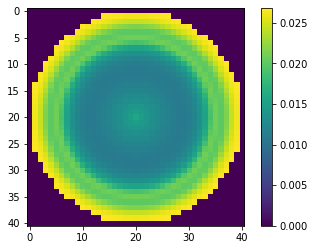

In [11]:
plt.imshow(ca.rule.nearest_neighbours.detach().cpu().numpy()[0, 0]); plt.colorbar();

Text(0.5, 1.0, 'Energy')

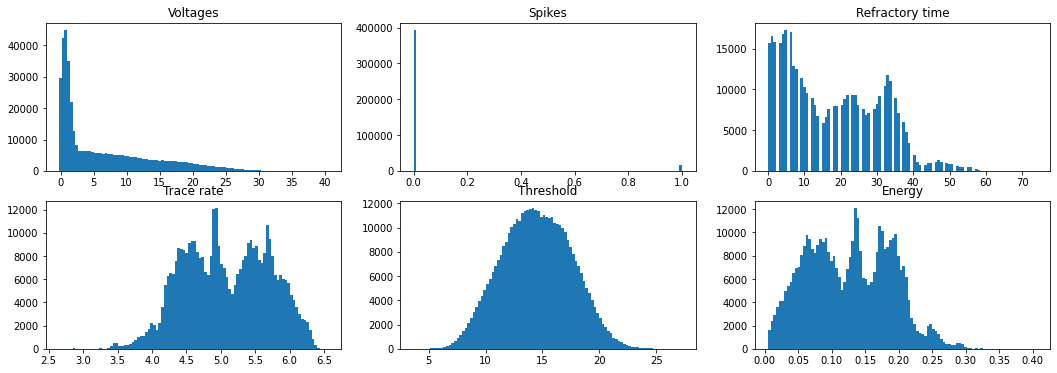

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(18, 6))
axes = axes.flatten()

axes[0].hist(state[0, 1].cpu().numpy().reshape(-1), 100);
axes[0].set_title('Voltages')
axes[1].hist(state[0, 0].cpu().numpy().reshape(-1), 100);
axes[1].set_title('Spikes')
axes[2].hist(state[0, 2].cpu().numpy().reshape(-1), 100);
axes[2].set_title('Refractory time')

axes[3].hist(state[0, 3].cpu().numpy().reshape(-1), 100)
axes[3].set_title('Trace rate')
axes[4].hist(state[0, 4].cpu().numpy().reshape(-1), 100)
axes[4].set_title('Threshold')
axes[5].hist(state[0, 5].cpu().numpy().reshape(-1), 100)
axes[5].set_title('Energy')

(array([ 81785.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 327815.]),
 array([-1.25 , -1.025, -0.8  , -0.575, -0.35 , -0.125,  0.1  ,  0.325,
         0.55 ,  0.775,  1.   ], dtype=float32),
 <BarContainer object of 10 artists>)

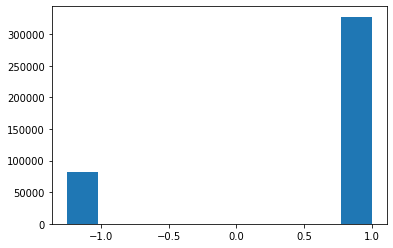

In [13]:
plt.hist(ca.rule.EI.cpu().numpy().reshape(-1))

In [14]:
xxx

NameError: name 'xxx' is not defined

In [ ]:
fname = time.strftime("%Y%m%d-%H%M%S")
# out = cv2.VideoWriter(f'videos/CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (RESX, RESY), 3)
out = cv2.VideoWriter(f'videos/CA-{fname}.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 24, (RESX, RESY), 1)


for img in imgs:
    img = np.uint8(cv2.cvtColor(img[0], cv2.COLOR_RGB2BGR)*255.0).transpose(1, 0, 2)
    out.write(img)
out.release()

In [ ]:
np.uint8(cv2.cvtColor(img[0], cv2.COLOR_RGB2BGR)*255.0).transpose(0, 1, 2).shape

In [ ]:
window = 10
for idx_start in np.arange(0, 400, 50):

    plt.figure(figsize=(12, 12))
    plt.imshow(np.mean(imgs[idx_start:idx_start + window], axis=0).transpose())
    plt.axis('off')
    
    # plt.savefig(f'poster_figs/t_ginger_f{str(idx_start).zfill(3)}.png', dpi=300, bbox_inches='tight')
    # plt.savefig(f'poster_figs/ginger_f{str(idx_start).zfill(3)}.png', dpi=300, bbox_inches='tight')
    # plt.savefig(f'poster_figs/memory_ginger_f{str(idx_start).zfill(3)}.png', dpi=300, bbox_inches='tight')

In [ ]:
ncol = 2
nrow = 4
fig, axes = plt.subplots(ncol, nrow, figsize=(nrow * 4, ncol * 4))

skip = int(len(imgs) / len(axes.flatten()))
for i, ax in enumerate(axes.flatten()):
    idx = i * skip
    ax.imshow(imgs[idx][0])
    ax.set_xlabel(f't={idx}')
    
plt.tight_layout()

In [ ]:
idx = 285
window = 1


plt.figure(figsize=(16, 5))

params = {'axes.labelsize': 16,
          'axes.titlesize': 24}
plt.rcParams.update(params)

plt.subplot(1, 4, 1)
plt.imshow(np.mean(imgs[idx:idx + window], axis=0)[0].transpose())
plt.title('Spikes')
plt.axis('tight')
plt.axis('scaled')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(np.mean(imgs[idx:idx + window], axis=0)[1].transpose())
plt.title('Voltages')
plt.axis('tight')
plt.axis('scaled')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(np.mean(imgs[idx:idx + window], axis=0)[2].transpose())
plt.title('Thresholds')
plt.axis('tight')
plt.axis('scaled')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(np.mean(imgs[idx:idx + window], axis=0)[3].transpose())
plt.title('Energy')
plt.axis('tight')
plt.axis('scaled')
plt.axis('off')


plt.tight_layout()
#plt.savefig('poster_figs/activity.pdf', bbox_inches='tight', dpi=300)
plt.savefig('poster_figs/activity.png', bbox_inches='tight', dpi=300)

In [ ]:
num_examples = 500
E_idxs = np.where((ca.rule.EI > 0.)[0, 0].reshape(-1).cpu().numpy())[0][0:num_examples]
I_idxs = np.where((ca.rule.EI < 0.)[0, 0].reshape(-1).cpu().numpy())[0][0:num_examples//4]

In [ ]:
raster_data_E = np.array(imgs).reshape(len(imgs), -1)[:, E_idxs].transpose()
raster_data_I = np.array(imgs).reshape(len(imgs), -1)[:, I_idxs].transpose()
st_E = [np.where(r) for r in raster_data_E]
st_I = [np.where(r) for r in raster_data_I]
ma_E = [img.reshape(-1)[E_idxs].mean() for img in imgs]
ma_I = [-1*img.reshape(-1)[I_idxs].mean() for img in imgs]

In [ ]:
def get_ISI_dist(S_e):
    ISI_Cov = []
    for s_t in np.transpose(S_e):
        S = np.diff(np.where(s_t))[0]
        ISI_Cov.append(np.std(S)/np.mean(S))
    return np.array(ISI_Cov)

CV_ISI_E = get_ISI_dist(raster_data_E.transpose())

In [ ]:
#params = {'axes.labelsize': 16,
#          'axes.titlesize': 24}
params = {'font.size': 22,
          'xtick.labelsize': 22,
          'ytick.labelsize': 22}
plt.rcParams.update(params)

axd = plt.figure(constrained_layout=True, figsize=(16, 6)).subplot_mosaic(
    """
    AAAD
    AAAD
    AAAC
    BBBC
    """
)

def RGB(x, y, z):
    return [x/255, y/255, z/255]

def darker(c, a):
    return [a*c_i for c_i in c]

def fix_axis(ax):
    # ax.set_xticks([])
    # ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.tick_params(axis='both', which='both', length=0)
    for key, spine in ax.spines.items():
        spine.set_visible(False)
        
our_red = RGB(215, 76, 94)
our_blue = RGB(61, 139, 190)

######## A ########
for i in range(len(st_E)):
    axd['A'].scatter(st_E[i][0], i * np.ones_like(st_E[i][0]), s=1, color=our_red)

for i in range(len(st_I)):
    axd['A'].scatter(st_I[i][0], -i * np.ones_like(st_I[i][0]), s=1, color=our_blue)

axd['A'].set_ylabel('index')
######## B ########
        
axd['B'].plot(ma_E, 'r', lw=2, alpha=0.75, c='k')
axd['B'].set_xlabel('time (ms)')
axd['B'].set_ylim([np.min(ma_E), np.max(ma_E)])

######## C ########

axd['C'].hist(CV_ISI_E, 25, density=True);
axd['C'].set_xlabel('CV (ISI)')

######## D ########

axd['D'].hist(np.mean(raster_data_E, axis=0) * 60, 25,density=True);
axd['D'].set_xlabel('Rates (Hz)')

for ax in axd.keys():
    fix_axis(axd[ax])

plt.tight_layout()
plt.savefig('poster_figs/network_dynamics.pdf', bbox_inches='tight', dpi=900, transparent=True)